# Introduction to TorchPhysics: Example 1

This notebook contains a template for the joint exercise regarding physics informed deep learning and TorchPhysics.

We start by solving the Laplace equation:

\begin{align*}
    \Delta u &= 1 &&\text{ in } \Omega \\
    u &= 0 , &&\text{ on } \partial \Omega
\end{align*}

with $\Omega = [0, 1] \times [0, 1]$.

First we have to install the library:

Next we implement the *Spaces* that appear in the problem:

In [1]:
import torch
import torchphysics as tp
import numpy as np
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
Re = tp.spaces.R1("re")
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')
F_X = tp.spaces.R1('fx')
F_Y = tp.spaces.R1('fy')

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.device_count()

0

Now we define our domain, the unit square:

In [3]:
X_interval = tp.domains.Interval(X, 0, 2.0) # <-add the bounds of the Interval (0, 2)
Y_interval = tp.domains.Interval(Y, 0, 2.0)
Re_interval = tp.domains.Interval(Re, 1, 500)
Sim_domain = X_interval*Y_interval*Re_interval


For the training we need to create some points, this is handle by the *Sampler*:

In [4]:

bound_sampler_low = tp.samplers.RandomUniformSampler(Y_interval.boundary_left*X_interval*Re_interval, n_points=250)

bound_sampler_up = tp.samplers.RandomUniformSampler(Y_interval.boundary_right*X_interval*Re_interval, n_points=1000)


In [5]:
def IBM_filter(y,x):
    return y[...,0]<=torch.sin(x[...,0]*np.pi*2)*0.1+0.15
    
IBM_sampler = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter)

In [6]:
def IBM_filter_2(y,x):
    return (y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1+0.1) & (y[...,0]<=torch.sin(x[...,0]*np.pi*2)*0.1+0.15)
    
IBM_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter_2)

In [7]:
def Inner_filter(y,x):
    return y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1+0.15

inner_sampler = tp.samplers.RandomUniformSampler(Sim_domain, n_points=5000,filter_fn=Inner_filter)

In [8]:
def Inner_filter_2(y,x):
    return (y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1+0.15)&(y[...,0]>torch.sin(x[...,0]*np.pi*2)*0.1+0.2)

inner_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain, n_points=1000,filter_fn=Inner_filter_2)

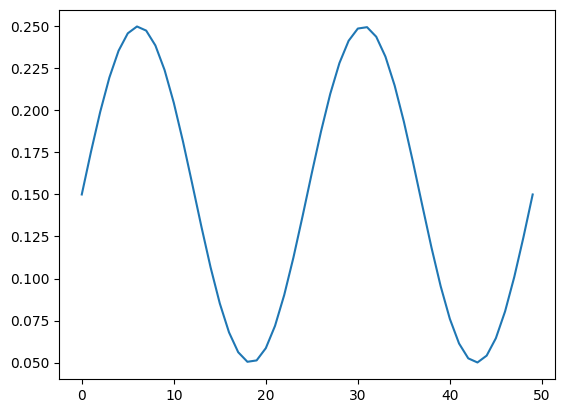

In [9]:
b=np.sin(np.linspace(0,2)*3.1415926*2)/10+0.15
import matplotlib.pyplot as plt
plt.plot(b)

We need a neural network that should learn our solution:

In [10]:
model = tp.models.FCN(input_space=X*Y*Re, output_space=U*V, hidden=(50,50,50,50,50,50))
#######Activation????

In [11]:
#tp.scatter(X*Y,IBM_sampler)

Now, we have to transform out mathematical conditions given by our PDE into corresponding training conditions. First for the differential equation itself:

In [12]:
inte_sampler = tp.samplers.RandomUniformSampler(X_interval.boundary*Y_interval, n_points=250)
x_inlet_sampler=tp.samplers.RandomUniformSampler(X_interval*Y_interval,n_points=250)

In [13]:
def init_bulk(u_integral):
    return u_integral-1
pde_cond_bulk=tp.conditions.IntegroPINNCondition(model,x_inlet_sampler,init_bulk,inte_sampler, weight=1)

In [14]:
def pde_IBM(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM = tp.conditions.PINNCondition(model, IBM_sampler, pde_IBM,weight=100,name='IBM')

In [15]:
def pde_IBM_2(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM_2 = tp.conditions.PINNCondition(model, IBM_sampler_2, pde_IBM_2,weight=100,name='IBM_2')

In [16]:
def pde_mass(u,v,x,y):
    return tp.utils.grad(u,x)+tp.utils.grad(v,y)-0.0
pde_cond_mass = tp.conditions.PINNCondition(model, inner_sampler, pde_mass,name='Conti')

In [17]:
def pde_residual_x(u,v, x, y,re):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/re + 20
    return residual_momentum

pde_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_x, pde_IBM,weight=10,name='Momentum_x')

In [18]:
def pde_residual_x_2(u,v, x, y,re):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/re + 20
    return residual_momentum

pde_cond_x_2 = tp.conditions.PINNCondition(model, inner_sampler_2, pde_residual_x_2, pde_IBM,weight=10,name='Momentum_x_2')

In [19]:
def pde_residual_y_2(u,v, x, y,re):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/re
    return residual_momentum

pde_cond_y_2 = tp.conditions.PINNCondition(model, inner_sampler_2, pde_residual_y_2, pde_IBM,weight=1,name='Momentum_y_2')

In [20]:
def pde_residual_y(u,v, x, y,re):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/re
    return residual_momentum

pde_cond_y = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_y, pde_IBM,weight=1,name='Momentum_y')

In [21]:
def boundary_residual(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))

boundary_cond = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual, weight=10,name='noslip')

In [22]:
def boundary_residual_x(u, x,y):
    return u - 0.0

boundary_cond_x = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_x, weight=1,name='noslip_x')

In [23]:
def boundary_residual_y(v, x,y):
    return v - 0.0

boundary_cond_y = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_y, weight=1,name='noslip_y')

In [24]:
Periodic_sampler=tp.samplers.RandomUniformSampler(Y_interval*Re_interval,n_points=2000)

In [25]:
def periodic_residual(u_left,u_right,v_left,v_right):
    Periodic_condition= torch.sqrt(torch.square(u_left)+torch.square(v_left)) - torch.sqrt(torch.square(u_right)+torch.square(v_right))
    return Periodic_condition
periodic_cond=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic')

In [26]:
def periodic_residual_x(u_left,u_right):
    Periodic_condition= u_left - u_right
    return Periodic_condition
periodic_cond_x=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_x,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_x')

In [27]:
def periodic_residual_y(v_left,v_right):
    Periodic_condition= v_left - v_right
    return Periodic_condition
periodic_cond_y=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_y,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_y')

Before the training we collect all conditions and choose our training procedure:

In [28]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001,scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,scheduler_args={"patience":1000,"factor":0.5,"verbose":True,"min_lr":0.000005},monitor_lr="train/loss")
#solver = tp.solver.Solver([pde_cond_IBM,pde_cond_mass,boundary_cond_x, pde_cond_x,periodic_cond_x,boundary_cond_y, pde_cond_y,periodic_cond_y], optimizer_setting=optim)
#optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_cond_IBM,#1000
                           pde_cond_IBM_2,#1000
                           boundary_cond,#1000
                           periodic_cond,#2000
                           pde_cond_x,#5000
                           pde_cond_y,#5000
                           pde_cond_mass,#5000
                           pde_cond_x_2,#1000
                           pde_cond_y_2],#1000
                          optimizer_setting=optim,
                         loss_function_schedule=[{
                        "conditions":[0,1,2,3],
                        "max_iter":5000
                    },
                     {
                        "conditions":[0,1,2,3,4,5,6],
                        "max_iter":8000
                    },
                                                                      {
                        "conditions":[0,1,2,3,6,7,8],
                        "max_iter":12000
                    }
                ])

Start the training:

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
comet_logger = pl_loggers.CSVLogger(save_dir="logs/")
trainer = pl.Trainer(gpus=0,# use one GPU
                     max_steps=10000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=comet_logger, # for writting into tensorboard
                     enable_checkpointing=False      ) # saving checkpoints
trainer.fit(solver)

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:273: RuntimeWarning: Found unsupported keys in the lr scheduler dict: {'patience', 'verbose', 'factor', 'min_lr'}. HINT: remove them from the output of `configure_optimizers`.
  rank_zero_warn(

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 13.1 K
1 | val_conditions   | ModuleList | 0     
------------

/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/net/istmhome/users/hi224/Dokumente/Python/TorchPhysics/TP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  24%|█████████████████████████████████                                                                                                      | 2447/10001 [02:19<07:09, 17.59it/s, loss=0.000856, v_num=34]

Lastly, we can plot the solution:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.close()

In [ ]:
def produce_sample(x_max,y_max,other_Constrains,resolution=100):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(0,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)
    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j],other_Constrains]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor[0,1]
    model_value_x=np.transpose(model_value_x)
    plt.contourf(XM,YM,model_value_x)
    plt.colorbar(label="U")
    x=np.linspace(0,2)
    y=np.sin(x*2*np.pi)*0.1+0.15
    plt.plot(x,y,"r")
    return model_value_x


In [ ]:
model_values=produce_sample(2,2,100)


In [ ]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,100] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*Re)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

In [ ]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,20] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

In [ ]:
coords = torch.tensor([[5,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))
coords = torch.tensor([[0,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))